# Estimate the Number of Experiment Repeats for Stochastic Machine Learning Algorithms
A problem with many stochastic machine learning algorithms is that different runs of the same algorithm on the same data return different results.

This means that when performing experiments to configure a stochastic algorithm or compare algorithms, you must collect multiple results and use the average performance to summarize the skill of the model.

This raises the question as to how many repeats of an experiment are enough to sufficiently characterize the skill of a stochastic machine learning algorithm for a given problem.

It is often recommended to use 30 or more repeats, or even 100. Some practitioners use thousands of repeats that seemingly push beyond the idea of diminishing returns.

In this tutorial, you will explore the statistical methods that you can use to estimate the right number of repeats to effectively characterize the performance of your stochastic machine learning algorithm.

Let’s get started.

## Tutorial Overview
This tutorial is broken down into 4 parts. They are:

1. Generate Data.
2. Basic Analysis.
3. Impact of the Number of Repeats.
4. Calculate Standard Error.

This tutorial assumes you have a working Python 2 or 3 SciPy environment installed with NumPy, Pandas and Matplotlib.

## 1. Generate Data
The first step is to generate some data.

We will pretend that we have fit a neural network or some other stochastic algorithm to a training dataset 1000 times and collected the final RMSE score on a dataset. We will further assume that the data is normally distributed, which is a requirement for the type of analysis we will use in this tutorial.

Always check the distribution of your results; more often than not the results will be Gaussian.

We will generate a population of results to analyze. This is useful as we will know the true population mean and standard deviation, which we would not know in a real scenario.

We will use a mean score of 60 with a standard deviation of 10.

The code below generates the sample of 1000 random results and saves them to a CSV file called results.csv.

We use the seed() function to seed the random number generator to ensure that we always get the same results each time this code is run (so you get the same numbers I do). We then use the normal() function to generate Gaussian random numbers and the savetxt() function to save the array of numbers in ASCII format.

In [1]:
from numpy.random import seed
from numpy.random import normal
from numpy import savetxt
# define underlying distribution of results
mean = 60
stev = 10
# generate samples from ideal distribution
seed(1)
results = normal(mean, stev, 1000)
# save to ASCII file
savetxt('results.csv', results)

You should now have a file called *results.csv* with 1000 final results from our pretend stochastic algorithm test harness.

We will forget that we know how these fake results were generated for the time being.

## 2. Basic Analysis
The first step when we have a population of results is to do some basic statistical analysis and see what we have.

Three useful tools for basic analysis include:

1. Calculate summary statistics, such as mean, standard deviation, and percentiles.
2. Review the spread of the data using a box and whisker plot.
3. Review the distribution of the data using a histogram.

The code below performs this basic analysis. First the *results.csv* is loaded, summary statistics are calculated, and plots are shown.

                 0
count  1000.000000
mean     60.388125
std       9.814950
min      29.462356
25%      53.998396
50%      60.412926
75%      67.039989
max      99.586027


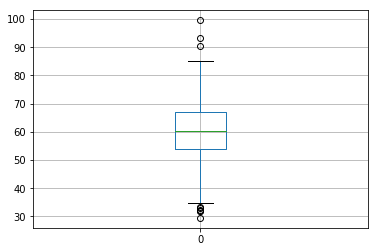

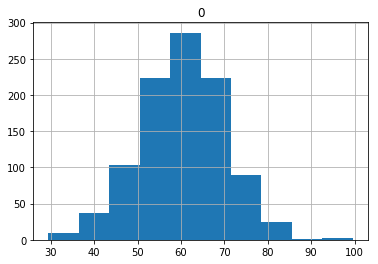

In [2]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from numpy import std
from matplotlib import pyplot
%matplotlib inline
# load results file
results = read_csv('results.csv', header=None)
# descriptive stats
print(results.describe())
# box and whisker plot
results.boxplot()
pyplot.show()
# histogram
results.hist()
pyplot.show()

Running the example first prints the summary statistics.

We can see that the average performance of the algorithm is about 60.3 units with a standard deviation of about 9.8.

If we assume the score is a minimizing score like RMSE, we can see that the worst performance was about 99.5 and the best performance was about 29.4.

A box and whisker plot is created to summarize the spread of the data, showing the middle 50% (box), outliers (dots), and the median (green line).

We can see that the spread of the results appears reasonable even around the median.

Finally, a histogram of the results is created. We can see the tell-tale bell curve shape of the Gaussian distribution, which is a good sign as it means we can use the standard statistical tools.

We do not see any obvious skew to the distribution; it seems centered around 60 or so.

## 3. Impact of the Number of Repeats
We have a lot of results, 1000 to be exact.

This may be far more results than we need, or not enough.

How do we know?

We can get a first-cut idea by plotting the number of repeats of an experiment against the average of scores from those repeats.

We would expect that as the number of repeats of the experiment increase, the average score would quickly stabilize. It should produce a plot that is initially noisy with a long tail of stability.

The code below creates this graph.

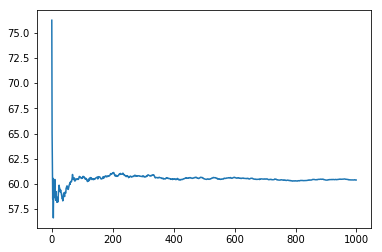

In [3]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from matplotlib import pyplot
%matplotlib inline
import numpy
# load results file
results = read_csv('results.csv', header=None)
values = results.values
# collect cumulative stats
means = list()
for i in range(1,len(values)+1):
	data = values[0:i, 0]
	mean_rmse = mean(data)
	means.append(mean_rmse)
# line plot of cumulative values
pyplot.plot(means)
pyplot.show()

The plot indeed shows a period of noisy average results for perhaps the first 200 repeats until it becomes stable. It appears to become even more stable after perhaps 600 repeats.

We can zoom in on this graph to the first 500 repeats to see if we can better understand what is happening.

We can also overlay the final mean score (mean from all 1000 runs) and attempt to locate a point of diminishing returns.

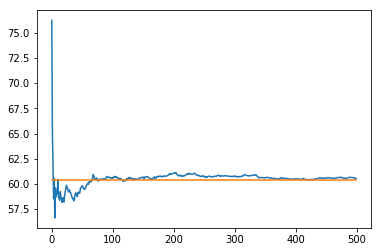

In [4]:
from pandas import DataFrame
from pandas import read_csv
from numpy import mean
from matplotlib import pyplot
%matplotlib inline
import numpy
# load results file
results = read_csv('results.csv', header=None)
values = results.values
final_mean = mean(values)
# collect cumulative stats
means = list()
for i in range(1,501):
	data = values[0:i, 0]
	mean_rmse = mean(data)
	means.append(mean_rmse)
# line plot of cumulative values
pyplot.plot(means)
pyplot.plot([final_mean for x in range(len(means))])
pyplot.show()

The orange line shows the mean of all 1000 runs.

We can see that 100 runs might be one good point to stop, otherwise perhaps 400 for a more refined result, but only slightly.

This is a good start, but can we do better?

## 4. Calculate Standard Error
Standard error is a calculation of how much the “sample mean” differences from the “population mean”.

This is different from standard deviation that describes the average amount of variation of observations within a sample.

The standard error can provide an indication for a given sample size the amount of error or the spread of error that may be expected from the sample mean to the underlying and unknown population mean.

Standard error can be calculated as follows:

In [ ]:
standard_error = sample_standard_deviation / sqrt(number of repeats)

That is in this context the standard deviation of the sample of model scores divided by the square root of the total number of repeats.

We would expect the standard error to decrease with the number of repeats of the experiment.

Given the results, we can calculate the standard error for the sample mean from the population mean at each number of repeats. The full code listing is provided below.

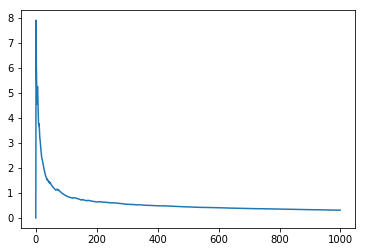

In [5]:
from pandas import read_csv
from numpy import std
from numpy import mean
from matplotlib import pyplot
%matplotlib inline
from math import sqrt
# load results file
results = read_csv('results.csv', header=None)
values = results.values
# collect cumulative stats
std_errors = list()
for i in range(1,len(values)+1):
	data = values[0:i, 0]
	stderr = std(data) / sqrt(len(data))
	std_errors.append(stderr)
# line plot of cumulative values
pyplot.plot(std_errors)
pyplot.show()

A line plot of standard error vs the number of repeats is created.

We can see that, as expected, as the number of repeats is increased, the standard error decreases. We can also see that there will be a point of acceptable error, say one or two units.

The units for standard error are the same as the units of the model skill.

We can recreate the above graph and draw the 0.5 and 1 units as guides that can be used to find an acceptable level of error.

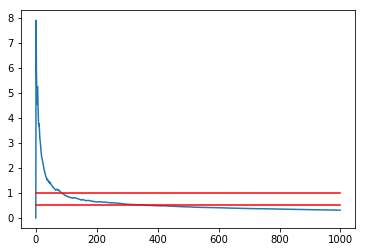

In [6]:
from pandas import read_csv
from numpy import std
from numpy import mean
from matplotlib import pyplot
%matplotlib inline
from math import sqrt
# load results file
results = read_csv('results.csv', header=None)
values = results.values
# collect cumulative stats
std_errors = list()
for i in range(1,len(values)+1):
	data = values[0:i, 0]
	stderr = std(data) / sqrt(len(data))
	std_errors.append(stderr)
# line plot of cumulative values
pyplot.plot(std_errors)
pyplot.plot([0.5 for x in range(len(std_errors))], color='red')
pyplot.plot([1 for x in range(len(std_errors))], color='red')
pyplot.show()

Again, we see the same line plot of standard error with red guidelines at a standard error of 1 and 0.5.

We can see that if a standard error of 1 was acceptable, then perhaps about 100 repeats would be sufficient. If a standard error of 0.5 was acceptable, perhaps 300-350 repeats would be sufficient.

We can see that the number of repeats quickly reaches a point of diminishing returns on standard error.

Again, remember, that standard error is a measure of how much the mean of the sample of model skill scores is wrong compared to the true underlying population of possible scores for a given model configuration given random initial conditions.

We can also use standard error as a confidence interval on the mean model skill.

For example, that the unknown population mean performance of a model has a likelihood of 95% of being between an upper and lower bound.

Note that this method is only appropriate for modest and large numbers of repeats, such as 20 or more.

The confidence interval can be defined as:

In [ ]:
sample mean +/- (standard error * 1.96)

We can calculate this confidence interval and add it to the sample mean for each number of repeats as error bars.

The full code listing is provided below.

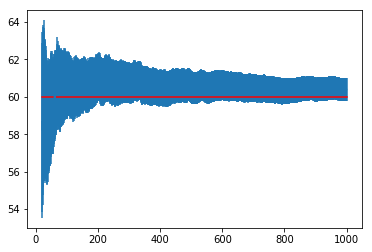

In [7]:
from pandas import read_csv
from numpy import std
from numpy import mean
from matplotlib import pyplot
%matplotlib inline
from math import sqrt
# load results file
results = read_csv('results.csv', header=None)
values = results.values
# collect cumulative stats
means, confidence = list(), list()
n = len(values) + 1
for i in range(20,n):
	data = values[0:i, 0]
	mean_rmse = mean(data)
	stderr = std(data) / sqrt(len(data))
	conf = stderr * 1.96
	means.append(mean_rmse)
	confidence.append(conf)
# line plot of cumulative values
pyplot.errorbar(range(20, n), means, yerr=confidence)
pyplot.plot(range(20, n), [60 for x in range(len(means))], color='red')
pyplot.show()

A line plot is created showing the mean sample value for each number of repeats with error bars showing the confidence interval of each mean value capturing the unknown underlying population mean.

A read line is drawn showing the actual population mean (known only because we contrived the model skill scores at the beginning of the tutorial). As a surrogate for the population mean, you could add a line of the final sample mean after 1000 repeats or more.

The error bars obscure the line of the mean scores. We can see that the mean overestimates the population mean but the 95% confidence interval captures the population mean.

Note that a 95% confidence interval means that 95 out of 100 sample means with the interval will capture the population mean, and 5 such sample means and confidence intervals will not.

We can see that the 95% confidence interval does appear to tighten up with the increase of repeats as the standard error decreases, but there is perhaps diminishing returns beyond 500 repeats.

We can get a clearer idea of what is going on by zooming this graph in, highlighting repeats from 20 to 200.

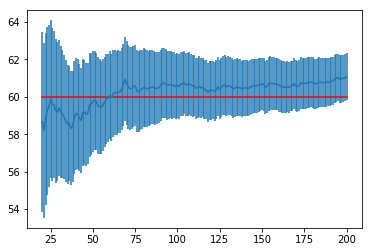

In [8]:
from pandas import read_csv
from numpy import std
from numpy import mean
from matplotlib import pyplot
%matplotlib inline
from math import sqrt
# load results file
results = read_csv('results.csv', header=None)
values = results.values
# collect cumulative stats
means, confidence = list(), list()
n = 200 + 1
for i in range(20,n):
	data = values[0:i, 0]
	mean_rmse = mean(data)
	stderr = std(data) / sqrt(len(data))
	conf = stderr * 1.96
	means.append(mean_rmse)
	confidence.append(conf)
# line plot of cumulative values
pyplot.errorbar(range(20, n), means, yerr=confidence)
pyplot.plot(range(20, n), [60 for x in range(len(means))], color='red')
pyplot.show()

In the line plot created, we can clearly see the sample mean and the symmetrical error bars around it. This plot does do a better job of showing the bias in the sample mean.

## Summary
In this tutorial, you discovered techniques that you can use to help choose the number of repeats that is right for evaluating stochastic machine learning algorithms.

You discovered a number of methods that you can use immediately:

* A rough guess of 30, 100, or 1000 repeats.
* Plot of sample mean vs number of repeats and choose based on inflection point.
* Plot of standard error vs number of repeats and choose based on error threshold.
* Plot of sample confidence interval vs number of repeats and choose based on spread of error.